# 라이브러리

In [13]:
import requests  # HTTP 요청을 보내기 위한 라이브러리 (API 호출 등)
import json      # JSON 데이터를 파싱하거나 문자열로 변환하기 위한 라이브러리
import time      # 시간 관련 함수 제공 (예: 지연, 타이머 등)
import pandas as pd  # 데이터 분석을 위한 라이브러리, DataFrame 구조 사용
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
from concurrent.futures import ThreadPoolExecutor  # 멀티스레딩을 위한 고수준 인터페이스 (병렬 처리 지원)

# 설정 및 도시 목록 정의

In [4]:
# Provided API key
API_KEY = "391047b25c8cacd63ff897a734825bac"
BASE_URL = "http://api.openweathermap.org/data/2.5/weather"

# 10 major cities selected via Google search
CITIES = [
    "Tokyo", "Delhi", "Shanghai", "Dhaka", "Cairo",
    "Sao Paulo", "Mexico City", "Beijing", "Mumbai", "New York"
]

# 날씨 데이터 크롤링 함수

In [14]:
def fetch_weather_data(city):
    """
    단일 도시의 날씨 데이터를 API로부터 가져오는 함수입니다.
    이 함수는 날씨 크롤링 작업의 가장 기본적인 단위로,
    API에 HTTP 요청을 보내고 응답을 파싱하여 필요한 정보를 추출합니다.
    네트워크 및 데이터 관련 예외를 처리하여 안정성을 확보합니다.
    """
    # API 요청에 필요한 매개변수를 정의합니다.
    # q: 도시 이름
    # appid: API 인증 키
    # units: 측정 단위 (metric은 섭씨를 의미)
    params = {
        "q": city,
        "appid": API_KEY,
        "units": "metric"
    }
    try:
        # API에 GET 요청을 보냅니다. 타임아웃을 5초로 설정하여 무한 대기를 방지합니다.
        response = requests.get(BASE_URL, params=params, timeout=5)
        # HTTP 응답 상태 코드가 200(성공)이 아니면 예외를 발생시킵니다.
        response.raise_for_status()
        
        # 응답 본문을 JSON 형식으로 파싱합니다.
        data = response.json()
        
        # 필요한 날씨 정보를 딕셔너리로 추출합니다.
        weather_info = {
            "city": city,
            "main_weather": data["weather"][0]["main"],
            "description": data["weather"][0]["description"],
            "temperature": data["main"]["temp"],
            "feels_like": data["main"]["feels_like"],
            "humidity": data["main"]["humidity"],
            "wind_speed": data["wind"]["speed"]
        }
        print(f"데이터를 성공적으로 가져왔습니다: {city}")
        return weather_info
        
    # requests 라이브러리에서 발생하는 모든 예외를 처리합니다.
    except requests.exceptions.RequestException as e:
        print(f"데이터 가져오기 오류 발생 ({city}): {e}")
        return None
    # JSON 디코딩 중 발생하는 오류를 처리합니다.
    except json.JSONDecodeError as e:
        print(f"JSON 디코딩 오류 발생 ({city}): {e}")
        return None
    # 딕셔너리에서 존재하지 않는 키에 접근할 때 발생하는 오류를 처리합니다.
    except KeyError as e:
        print(f"데이터에서 키가 누락되었습니다 ({city}): {e}")
        return None

def crawl_single_threaded(cities):
    """
    단일 스레드에서 모든 도시의 날씨 데이터를 순차적으로 크롤링합니다.
    이 함수는 각 도시의 날씨 데이터를 하나씩 순서대로 처리하며,
    네트워크 요청 사이에 작은 지연 시간을 두어 서버 부하를 줄입니다.
    작업 시작부터 완료까지 걸린 총 시간을 측정하여 반환합니다.
    """
    print("\n--- 순차적(단일 스레드) 크롤링 시작 ---")
    start_time = time.time()
    all_weather_data = []
    
    # 도시 리스트를 순회하며 각 도시의 날씨 데이터를 가져옵니다.
    for city in cities:
        data = fetch_weather_data(city)
        if data:
            all_weather_data.append(data)
        time.sleep(0.5)  # 서버 부하를 줄이기 위해 0.5초 지연
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- 순차적 크롤링 완료. 소요 시간: {elapsed_time:.2f}초 ---")
    return all_weather_data, elapsed_time

def crawl_multi_threaded(cities, max_threads=10):
    """
    여러 스레드를 사용하여 모든 도시의 날씨 데이터를 병렬로 크롤링합니다.
    이 함수는 ThreadPoolExecutor를 활용하여 여러 작업을 동시에 실행함으로써,
    네트워크 I/O가 대부분인 작업에서 성능을 크게 향상시킵니다.
    동시에 실행할 스레드의 최대 개수를 설정하여 자원 사용을 최적화합니다.
    """
    print(f"\n--- 병렬적(멀티 스레드) 크롤링 시작 (최대 {max_threads} 스레드) ---")
    start_time = time.time()
    all_weather_data = []
    
    # ThreadPoolExecutor를 사용하여 스레드 풀을 생성합니다.
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        # 각 도시별로 fetch_weather_data 함수를 실행하는 '퓨처(Future)' 객체를 생성합니다.
        futures = [executor.submit(fetch_weather_data, city) for city in cities]
        
        # 각 퓨처의 결과를 가져와서 all_weather_data 리스트에 추가합니다.
        for future in futures:
            data = future.result()
            if data:
                all_weather_data.append(data)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- 병렬적 크롤링 완료. 소요 시간: {elapsed_time:.2f}초 ---")
    return all_weather_data, elapsed_time

In [ ]:
def fetch_weather_data(city):
    params = {
        "q": city,
        "appid": API_KEY,
        "units": "metric"
    }
    try:
        response = requests.get(BASE_URL, params=params, timeout=5)
        response.raise_for_status()
        data = response.json()
        weather_info = {
            "city": city,
            "main_weather": data["weather"][0]["main"],
            "description": data["weather"][0]["description"],
            "temperature": data["main"]["temp"],
            "feels_like": data["main"]["feels_like"],
            "humidity": data["main"]["humidity"],
            "wind_speed": data["wind"]["speed"]
        }
        print(f"데이터를 성공적으로 가져왔습니다: {city}")
        return weather_info
    except requests.exceptions.RequestException as e:
        print(f"데이터 가져오기 오류 발생 ({city}): {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"JSON 디코딩 오류 발생 ({city}): {e}")
        return None
    except KeyError as e:
        print(f"데이터에서 키가 누락되었습니다 ({city}): {e}")
        return None

def crawl_single_threaded(cities):
    print("\n--- 순차적(단일 스레드) 크롤링 시작 ---")
    start_time = time.time()
    all_weather_data = []
    for city in cities:
        data = fetch_weather_data(city)
        if data:
            all_weather_data.append(data)
        time.sleep(0.5)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- 순차적 크롤링 완료. 소요 시간: {elapsed_time:.2f}초 ---")
    return all_weather_data, elapsed_time

def crawl_multi_threaded(cities, max_threads=10):
    print(f"\n--- 병렬적(멀티 스레드) 크롤링 시작 (최대 {max_threads} 스레드) ---")
    start_time = time.time()
    all_weather_data = []
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(fetch_weather_data, city) for city in cities]
        for future in futures:
            data = future.result()
            if data:
                all_weather_data.append(data)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"--- 병렬적 크롤링 완료. 소요 시간: {elapsed_time:.2f}초 ---")
    return all_weather_data, elapsed_time


# 데이터 수집

In [15]:
# 단일스레드 실행
weather_data_single, time_single = crawl_single_threaded(CITIES)

# 멀티스레드 실행
weather_data_multi, time_multi = crawl_multi_threaded(CITIES, max_threads=5)


--- 순차적(단일 스레드) 크롤링 시작 ---
데이터를 성공적으로 가져왔습니다: Tokyo
데이터를 성공적으로 가져왔습니다: Delhi
데이터를 성공적으로 가져왔습니다: Shanghai
데이터를 성공적으로 가져왔습니다: Dhaka
데이터를 성공적으로 가져왔습니다: Cairo
데이터를 성공적으로 가져왔습니다: Sao Paulo
데이터를 성공적으로 가져왔습니다: Mexico City
데이터를 성공적으로 가져왔습니다: Beijing
데이터를 성공적으로 가져왔습니다: Mumbai
데이터를 성공적으로 가져왔습니다: New York
--- 순차적 크롤링 완료. 소요 시간: 8.13초 ---

--- 병렬적(멀티 스레드) 크롤링 시작 (최대 5 스레드) ---
데이터를 성공적으로 가져왔습니다: Tokyo
데이터를 성공적으로 가져왔습니다: Cairo
데이터를 성공적으로 가져왔습니다: Dhaka
데이터를 성공적으로 가져왔습니다: Shanghai
데이터를 성공적으로 가져왔습니다: Delhi
데이터를 성공적으로 가져왔습니다: Mumbai
데이터를 성공적으로 가져왔습니다: Sao Paulo
데이터를 성공적으로 가져왔습니다: Mexico City
데이터를 성공적으로 가져왔습니다: Beijing
데이터를 성공적으로 가져왔습니다: New York
--- 병렬적 크롤링 완료. 소요 시간: 0.60초 ---


# 수집결과 출력 및 저장

In [16]:
# 단일 스레드 방식으로 수집된 날씨 데이터가 있을 경우 실행
if weather_data_single:
    # 데이터를 DataFrame으로 변환
    df_single = pd.DataFrame(weather_data_single)
    print("\n--- 단일 스레드 수집 데이터 중 앞 3개 행 출력 ---")
    print(df_single.head(3))
    
    # CSV 파일로 저장
    csv_file_single = "weather_data_single.csv"
    df_single.to_csv(csv_file_single, index=False, encoding='utf-8')
    print(f"\n단일 스레드 날씨 데이터를 CSV로 저장했습니다: {csv_file_single}")
    
    # JSONL 파일로 저장
    jsonl_file_single = "weather_data_single.jsonl"
    with open(jsonl_file_single, 'w', encoding='utf-8') as f:
        for record in weather_data_single:
            f.write(json.dumps(record, ensure_ascii=False) + '\n')
    print(f"단일 스레드 날씨 데이터를 JSONL로 저장했습니다: {jsonl_file_single}")

# 멀티 스레드 방식으로 수집된 날씨 데이터가 있을 경우 실행
if weather_data_multi:
    # 데이터를 DataFrame으로 변환
    df_multi = pd.DataFrame(weather_data_multi)
    print("\n--- 멀티 스레드 수집 데이터 중 앞 3개 행 출력 ---")
    print(df_multi.head(3))

    # CSV 파일로 저장
    csv_file_multi = "weather_data_multi.csv"
    df_multi.to_csv(csv_file_multi, index=False, encoding='utf-8')
    print(f"\n멀티 스레드 날씨 데이터를 CSV로 저장했습니다: {csv_file_multi}")
    
    # JSONL 파일로 저장
    jsonl_file_multi = "weather_data_multi.jsonl"
    with open(jsonl_file_multi, 'w', encoding='utf-8') as f:
        for record in weather_data_multi:
            f.write(json.dumps(record, ensure_ascii=False) + '\n')
    print(f"멀티 스레드 날씨 데이터를 JSONL로 저장했습니다: {jsonl_file_multi}")



--- 단일 스레드 수집 데이터 중 앞 3개 행 출력 ---
       city main_weather    description  temperature  feels_like  humidity  \
0     Tokyo       Clouds  broken clouds        29.86       33.80        66   
1     Delhi         Mist           mist        27.05       30.77        89   
2  Shanghai       Clouds  broken clouds        31.92       38.92        74   

   wind_speed  
0        8.23  
1        2.06  
2        5.00  

단일 스레드 날씨 데이터를 CSV로 저장했습니다: weather_data_single.csv
단일 스레드 날씨 데이터를 JSONL로 저장했습니다: weather_data_single.jsonl

--- 멀티 스레드 수집 데이터 중 앞 3개 행 출력 ---
       city main_weather    description  temperature  feels_like  humidity  \
0     Tokyo       Clouds  broken clouds        29.86       33.80        66   
1     Delhi         Mist           mist        27.05       30.77        89   
2  Shanghai       Clouds  broken clouds        31.92       38.92        74   

   wind_speed  
0        8.23  
1        2.06  
2        5.00  

멀티 스레드 날씨 데이터를 CSV로 저장했습니다: weather_data_multi.csv
멀티 스레드 날씨 데이터를 

# 결과 비교 차트

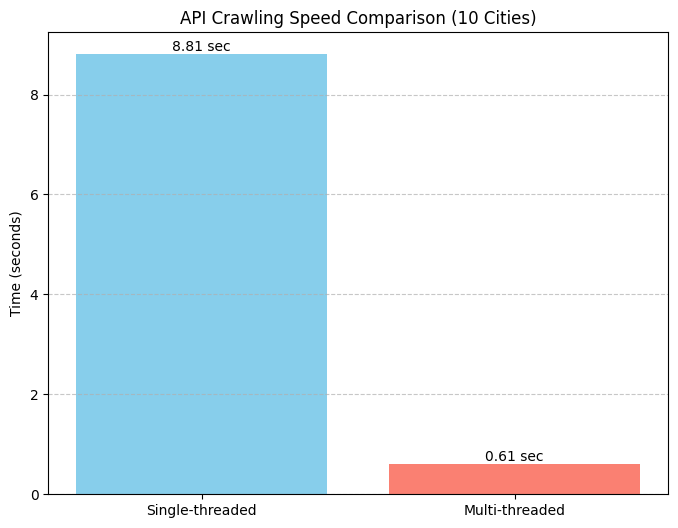

In [12]:
plt.figure(figsize=(8, 6))
bars = plt.bar(
    ["Single-threaded", "Multi-threaded"], 
    [time_single, time_multi],
    color=['skyblue', 'salmon']
)
plt.ylabel("Time (seconds)")
plt.title("API Crawling Speed Comparison (10 Cities)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the time value on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f} sec", va='bottom', ha='center')
    
plt.show()


--- Starting Single-threaded Crawling ---
✅ Data fetched for Tokyo
✅ Data fetched for Delhi
✅ Data fetched for Shanghai
✅ Data fetched for Dhaka
✅ Data fetched for Cairo
✅ Data fetched for Sao Paulo
✅ Data fetched for Mexico City
✅ Data fetched for Beijing
✅ Data fetched for Mumbai
✅ Data fetched for New York
--- Single-threaded Crawling Completed in 8.65 seconds ---

--- Starting Multi-threaded Crawling (Max 5 threads) ---
✅ Data fetched for Tokyo
✅ Data fetched for Shanghai
✅ Data fetched for Dhaka
✅ Data fetched for Delhi
✅ Data fetched for Cairo
✅ Data fetched for Sao Paulo
✅ Data fetched for Beijing
✅ Data fetched for Mumbai
✅ Data fetched for Mexico City
✅ Data fetched for New York
--- Multi-threaded Crawling Completed in 0.62 seconds ---

--- Displaying the first 3 rows of Single-threaded Data ---
       city main_weather    description  temperature  feels_like  humidity  \
0     Tokyo       Clouds  broken clouds        29.94       33.75        65   
1     Delhi         Mist   

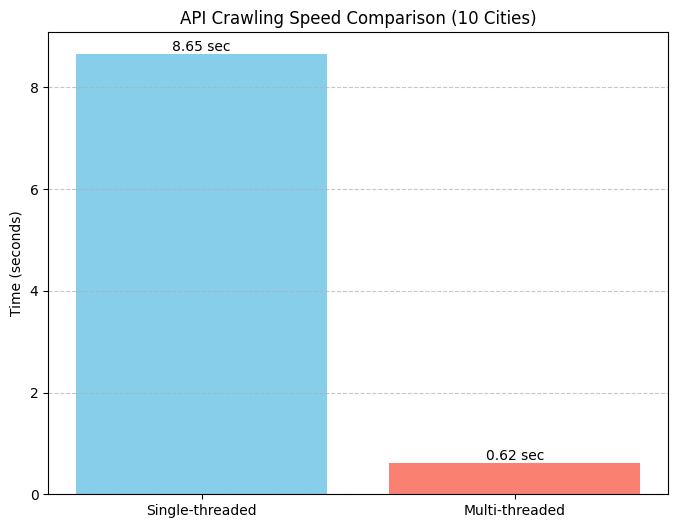